In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


In [13]:
def load_saved_data(pkl_path="./data/data.pkl", train_npy="./results/GConvGRU_train.npy", test_npy="./results/GConvGRU_test.npy", tr_ratio=0.8):
    """
    저장된 데이터를 불러와서 훈련/테스트 데이터로 분할하는 함수.

    Args:
        pkl_path (str): 저장된 피클 파일 경로
        train_npy (str): 훈련 데이터 NumPy 파일 경로
        test_npy (str): 테스트 데이터 NumPy 파일 경로
        tr_ratio (float): 훈련 데이터 비율

    Returns:
        dict: 훈련 및 테스트 데이터가 포함된 딕셔너리
    """
    # .pkl 파일에서 데이터 불러오기
    with open(pkl_path, "rb") as f:
        data_loaded = pickle.load(f)

    # 기본 변수 할당
    y, yU, yP = data_loaded["y"], data_loaded["yU"], data_loaded["yP"]
    t, regions = data_loaded["t"], data_loaded["regions"]

    # 훈련/테스트 데이터 분할
    total_time_steps = len(t)
    train_size = int(np.floor(total_time_steps * tr_ratio))
    
    data_split = {
        "t_train": t[:train_size],
        "t_test": t[train_size:],
        "y_train": y[:train_size, :],
        "y_test": y[train_size:, :],
        "regions": regions
    }

    # NumPy 파일 불러오기 (yhat, yUhat, yPhat)
    data_split["yhat_train"], data_split["yUhat_train"], data_split["yPhat_train"] = np.load(train_npy)
    data_split["yhat_test"], data_split["yUhat_test"], data_split["yPhat_test"] = np.load(test_npy)

    return data_split

# 데이터 불러오기
data = load_saved_data(
    pkl_path="./data/data.pkl", 
    train_npy="./results/GConvGRU_train.npy", 
    test_npy="./results/GConvGRU_test.npy", 
    tr_ratio=0.8
)

# 필요한 변수 할당
t_train, t_test = data["t_train"], data["t_test"]
y_train, y_test = data["y_train"], data["y_test"]
yhat_train, yhat_test = data["yhat_train"], data["yhat_test"]
yUhat_train, yUhat_test = data["yUhat_train"], data["yUhat_test"]
yPhat_train, yPhat_test = data["yPhat_train"], data["yPhat_test"]
regions = data["regions"]

In [ ]:
def plot_prediction_results(t, y, yhat, yUhat, yPhat, regions, city, tr_ratio=0.8, save_path="prediction_results.pdf"):
    """
    훈련 및 테스트 예측 결과를 시각화하는 함수.

    Args:
        t (pd.Series): 시간 정보.
        y (np.ndarray): 실제 값.
        yhat (np.ndarray): 기존 모델 예측값.
        yUhat (np.ndarray): 개선 모델 (U) 예측값.
        yPhat (np.ndarray): 개선 모델 (P) 예측값.
        regions (list): 지역 목록.
        city (int): 시각화할 지역 인덱스.
        tr_ratio (float, optional): 훈련 데이터 비율 (default: 0.8).
        save_path (str, optional): 저장할 PDF 파일 경로.
    """
    # 데이터 분할
    total_time_steps = len(t)
    train_size = int(np.floor(total_time_steps * tr_ratio))
    test_size = total_time_steps - train_size

    t_train, t_test = t[:train_size], t[train_size:] if test_size > 0 else None
    y_train, y_test = y[:train_size, :], y[train_size:, :] if test_size > 0 else None
    yhat_train, yhat_test = yhat[:train_size, :], yhat[train_size:, :] if test_size > 0 else None
    yUhat_train, yUhat_test = yUhat[:train_size, :], yUhat[train_size:, :] if test_size > 0 else None
    yPhat_train, yPhat_test = yPhat[:train_size, :], yPhat[train_size:, :] if test_size > 0 else None

    # 스타일 설정
    sns.set_style("whitegrid")
    
    fig, ax = plt.subplots(figsize=(14, 3), dpi=300)  # ✅ 높이 4, 해상도 300dpi로 설정

    # 컬러 팔레트
    real_color = "#2E3B4E"    # 어두운 네이비 (Real)
    classic_color = "#E74C3C"  # 빨강 (Classic)
    proposed_color = "#3498DB"  # 블루 (Proposed)
    test_real_color = "#95A5A6"  # 회색 (Test Real)

    # ✅ 선 두께 얇게 조정
    line_width = 0.8
    alpha_train = 0.8
    alpha_test = 0.6

    # Train 데이터 시각화
    ax.plot(t_train, y_train[:, city], '-', label='Real (Train)', color=real_color, linewidth=line_width)
    ax.plot(t_train, yhat_train[:, city], '-', label='Classic (Train)', color=classic_color, alpha=alpha_train, linewidth=line_width)
    ax.plot(t_train, (yUhat_train * yPhat_train)[:, city], '-', label='Proposed (Train)', color=proposed_color, alpha=alpha_train, linewidth=line_width)

    # Test 데이터 시각화 (데이터가 있는 경우)
    if test_size > 0:
        ax.plot(t_test, y_test[:, city], '--', label='Real (Test)', color=test_real_color, linewidth=line_width)
        ax.plot(t_test, yhat_test[:, city], '--', label='Classic (Test)', color=classic_color, alpha=alpha_test, linewidth=line_width)
        ax.plot(t_test, (yUhat_test * yPhat_test)[:, city], '--', label='Proposed (Test)', color=proposed_color, alpha=alpha_test, linewidth=line_width)

    # X축 설정 (날짜 포맷)
    interval = max(1, len(t_train) // 10)  # 적절한 간격 설정
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d.'))
    plt.xticks(rotation=25, ha='right')

    # 제목 설정
    train_start = t_train.iloc[0].strftime('%Y.%m.%d.')
    test_end = t_test.iloc[-1].strftime('%Y.%m.%d.') if test_size > 0 else "N/A"
    ax.set_title(f"Prediction Results for {regions[city]} ({train_start} - {test_end})", fontsize=12)

    # 라벨 및 범례 추가
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Solar Radiation", fontsize=10)
    ax.legend(frameon=True, fontsize=10, loc="upper left")
    ax.grid(True, linestyle="--", alpha=0.5)

    # ✅ PDF로 저장
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"✅ 그래프가 '{save_path}'에 저장되었습니다.")

    # 그래프 출력
    plt.show()

✅ 그래프가 'fig1.pdf'에 저장되었습니다.


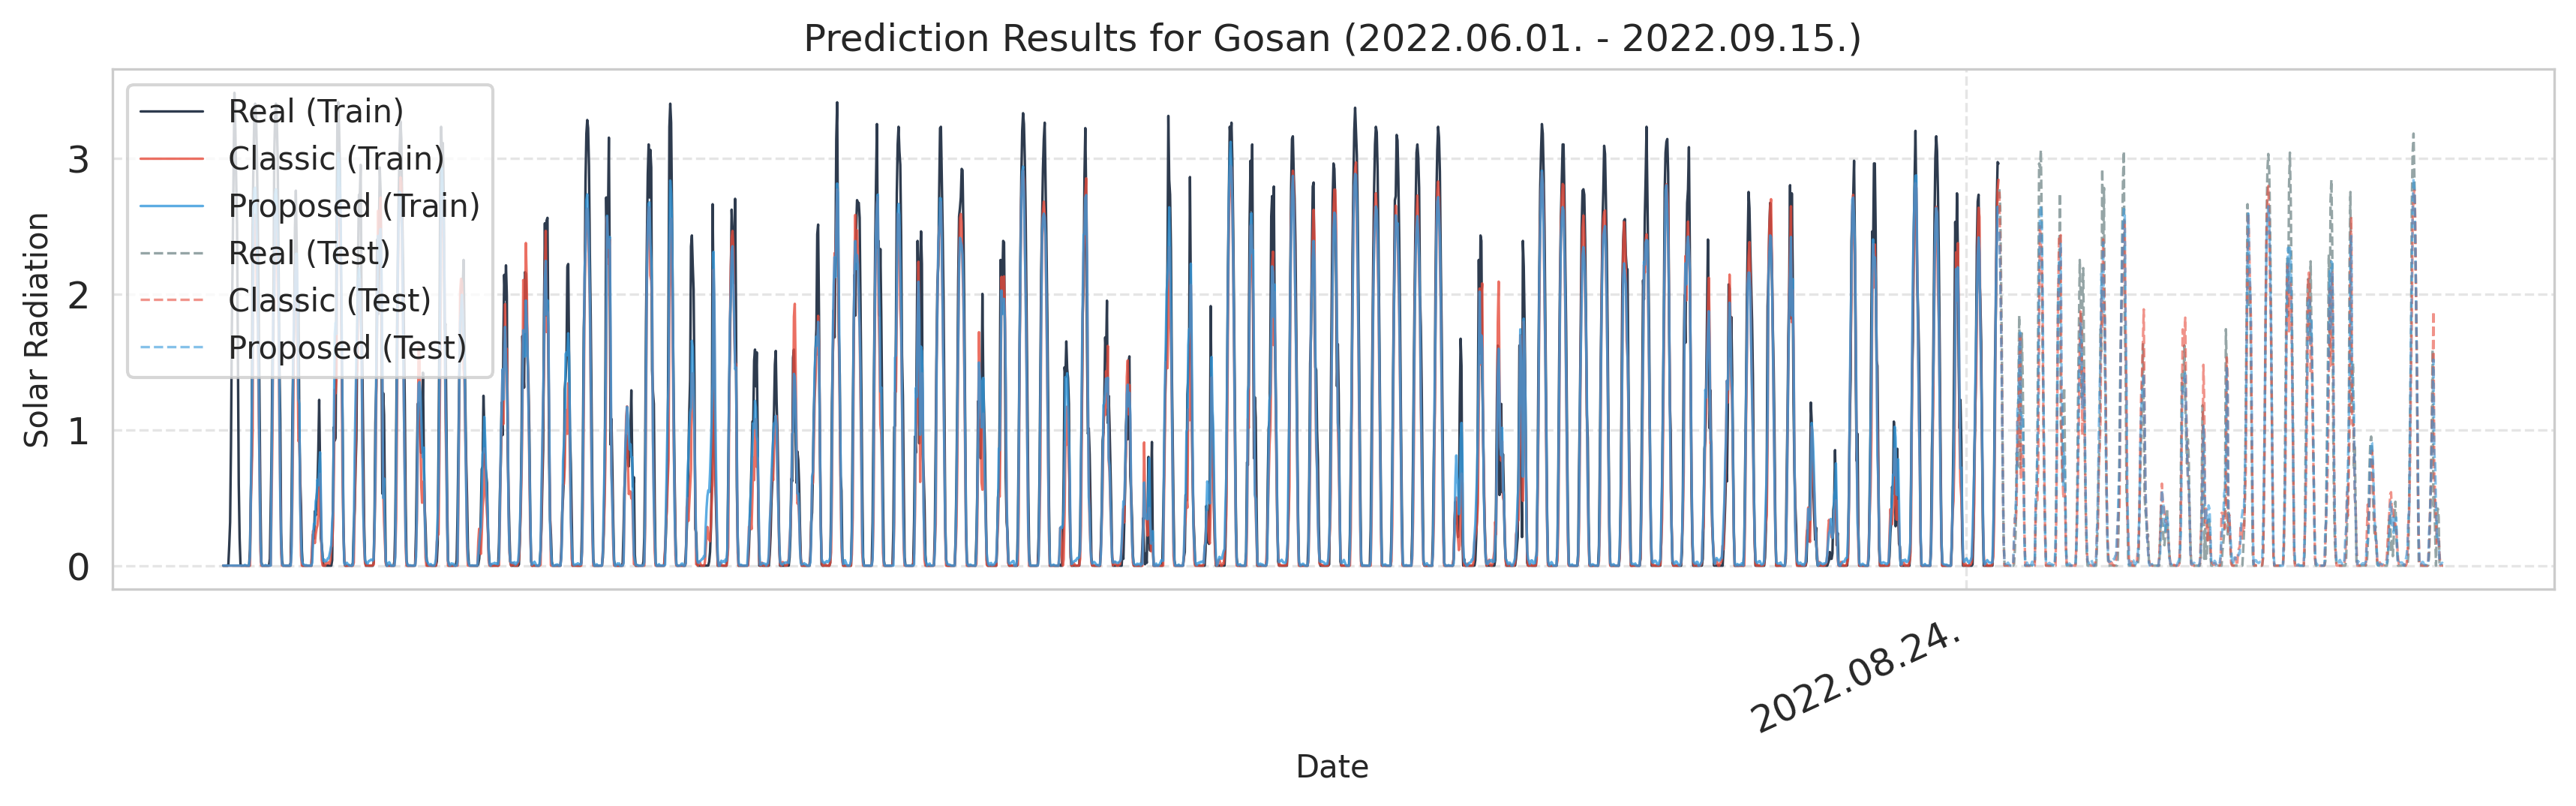

In [ ]:
plot_prediction_results(t, y, yhat, yUhat, yPhat, regions, city=29, save_path="fig1.pdf")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_test_results_multiple(t_test, y_test, yhat_test, yUhat_test, yPhat_test, regions, city_indices, save_path="test_results_multiple.pdf"):
    """
    여러 지역의 테스트 데이터 예측 결과를 subplot으로 시각화하는 함수.
    Y축 라벨을 가운데 정렬하여 가독성 개선.

    Args:
        t_test (pd.Series): 테스트 구간의 시간 정보.
        y_test (np.ndarray): 실제 값 (테스트).
        yhat_test (np.ndarray): 기존 모델 예측값 (테스트).
        yUhat_test (np.ndarray): 개선 모델 (U) 예측값 (테스트).
        yPhat_test (np.ndarray): 개선 모델 (P) 예측값 (테스트).
        regions (list): 지역 목록.
        city_indices (list): 시각화할 지역 인덱스 리스트.
        save_path (str, optional): 저장할 PDF 파일 경로.
    """
    if t_test is None or len(t_test) == 0:
        print("⚠ 테스트 데이터가 없습니다. 그래프를 그릴 수 없습니다.")
        return

    num_cities = len(city_indices)
    fig, axes = plt.subplots(nrows=num_cities, ncols=1, figsize=(14, 2.8 * num_cities), dpi=300, sharex=True)  # ✅ 높이 조정

    # 컬러 설정
    real_color = "#2E3B4E"      # 어두운 네이비 (Real)
    classic_color = "#E74C3C"   # 빨강 (Classic)
    proposed_color = "#3498DB"  # 블루 (Proposed)

    line_width = 1.2  # ✅ 선 굵기 줄이기
    alpha_test = 0.7  # ✅ 투명도 조정

    for i, city in enumerate(city_indices):
        ax = axes[i] if num_cities > 1 else axes  # 단일 subplot 처리

        # 데이터 플롯
        ax.plot(t_test, y_test[:, city], '-', label='Real', color=real_color, linewidth=line_width, alpha=0.9)
        ax.plot(t_test, yhat_test[:, city], '--', label='Classic', color=classic_color, alpha=alpha_test, linewidth=line_width)
        ax.plot(t_test, (yUhat_test * yPhat_test)[:, city], '--', label='Proposed', color=proposed_color, alpha=alpha_test, linewidth=line_width)

        # 지역명 타이틀 추가
        ax.set_title(f"{regions[city]}", fontsize=12, fontweight='bold', pad=10)

        # Y축 라벨 (첫 번째 subplot만 일반 위치, 나머지는 중앙 정렬)
        if i == num_cities // 2:  # 중간 subplot에만 표시
            ax.set_ylabel("Solar Radiation", fontsize=12, labelpad=30)

        # 격자 설정
        ax.grid(True, linestyle="--", alpha=0.5)

    # ✅ X축 설정 (하루 간격)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d.'))
    plt.xticks(rotation=25, ha='right')

    # ✅ 전체 범례 설정 (subplot 개별 범례 제거 후 중앙 배치)
    handles, labels = axes[0].get_legend_handles_labels() if num_cities > 1 else ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=11, frameon=True, framealpha=0.8)

    # ✅ X축 공통 라벨 추가
    fig.text(0.5, 0.01, "Date", ha='center', fontsize=12)

    # ✅ PDF 저장
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"✅ 여러 지역의 테스트 데이터 그래프가 '{save_path}'에 저장되었습니다.")

    # 그래프 출력
    plt.show()

✅ 여러 지역의 테스트 데이터 그래프가 'test_results_multiple.pdf'에 저장되었습니다.


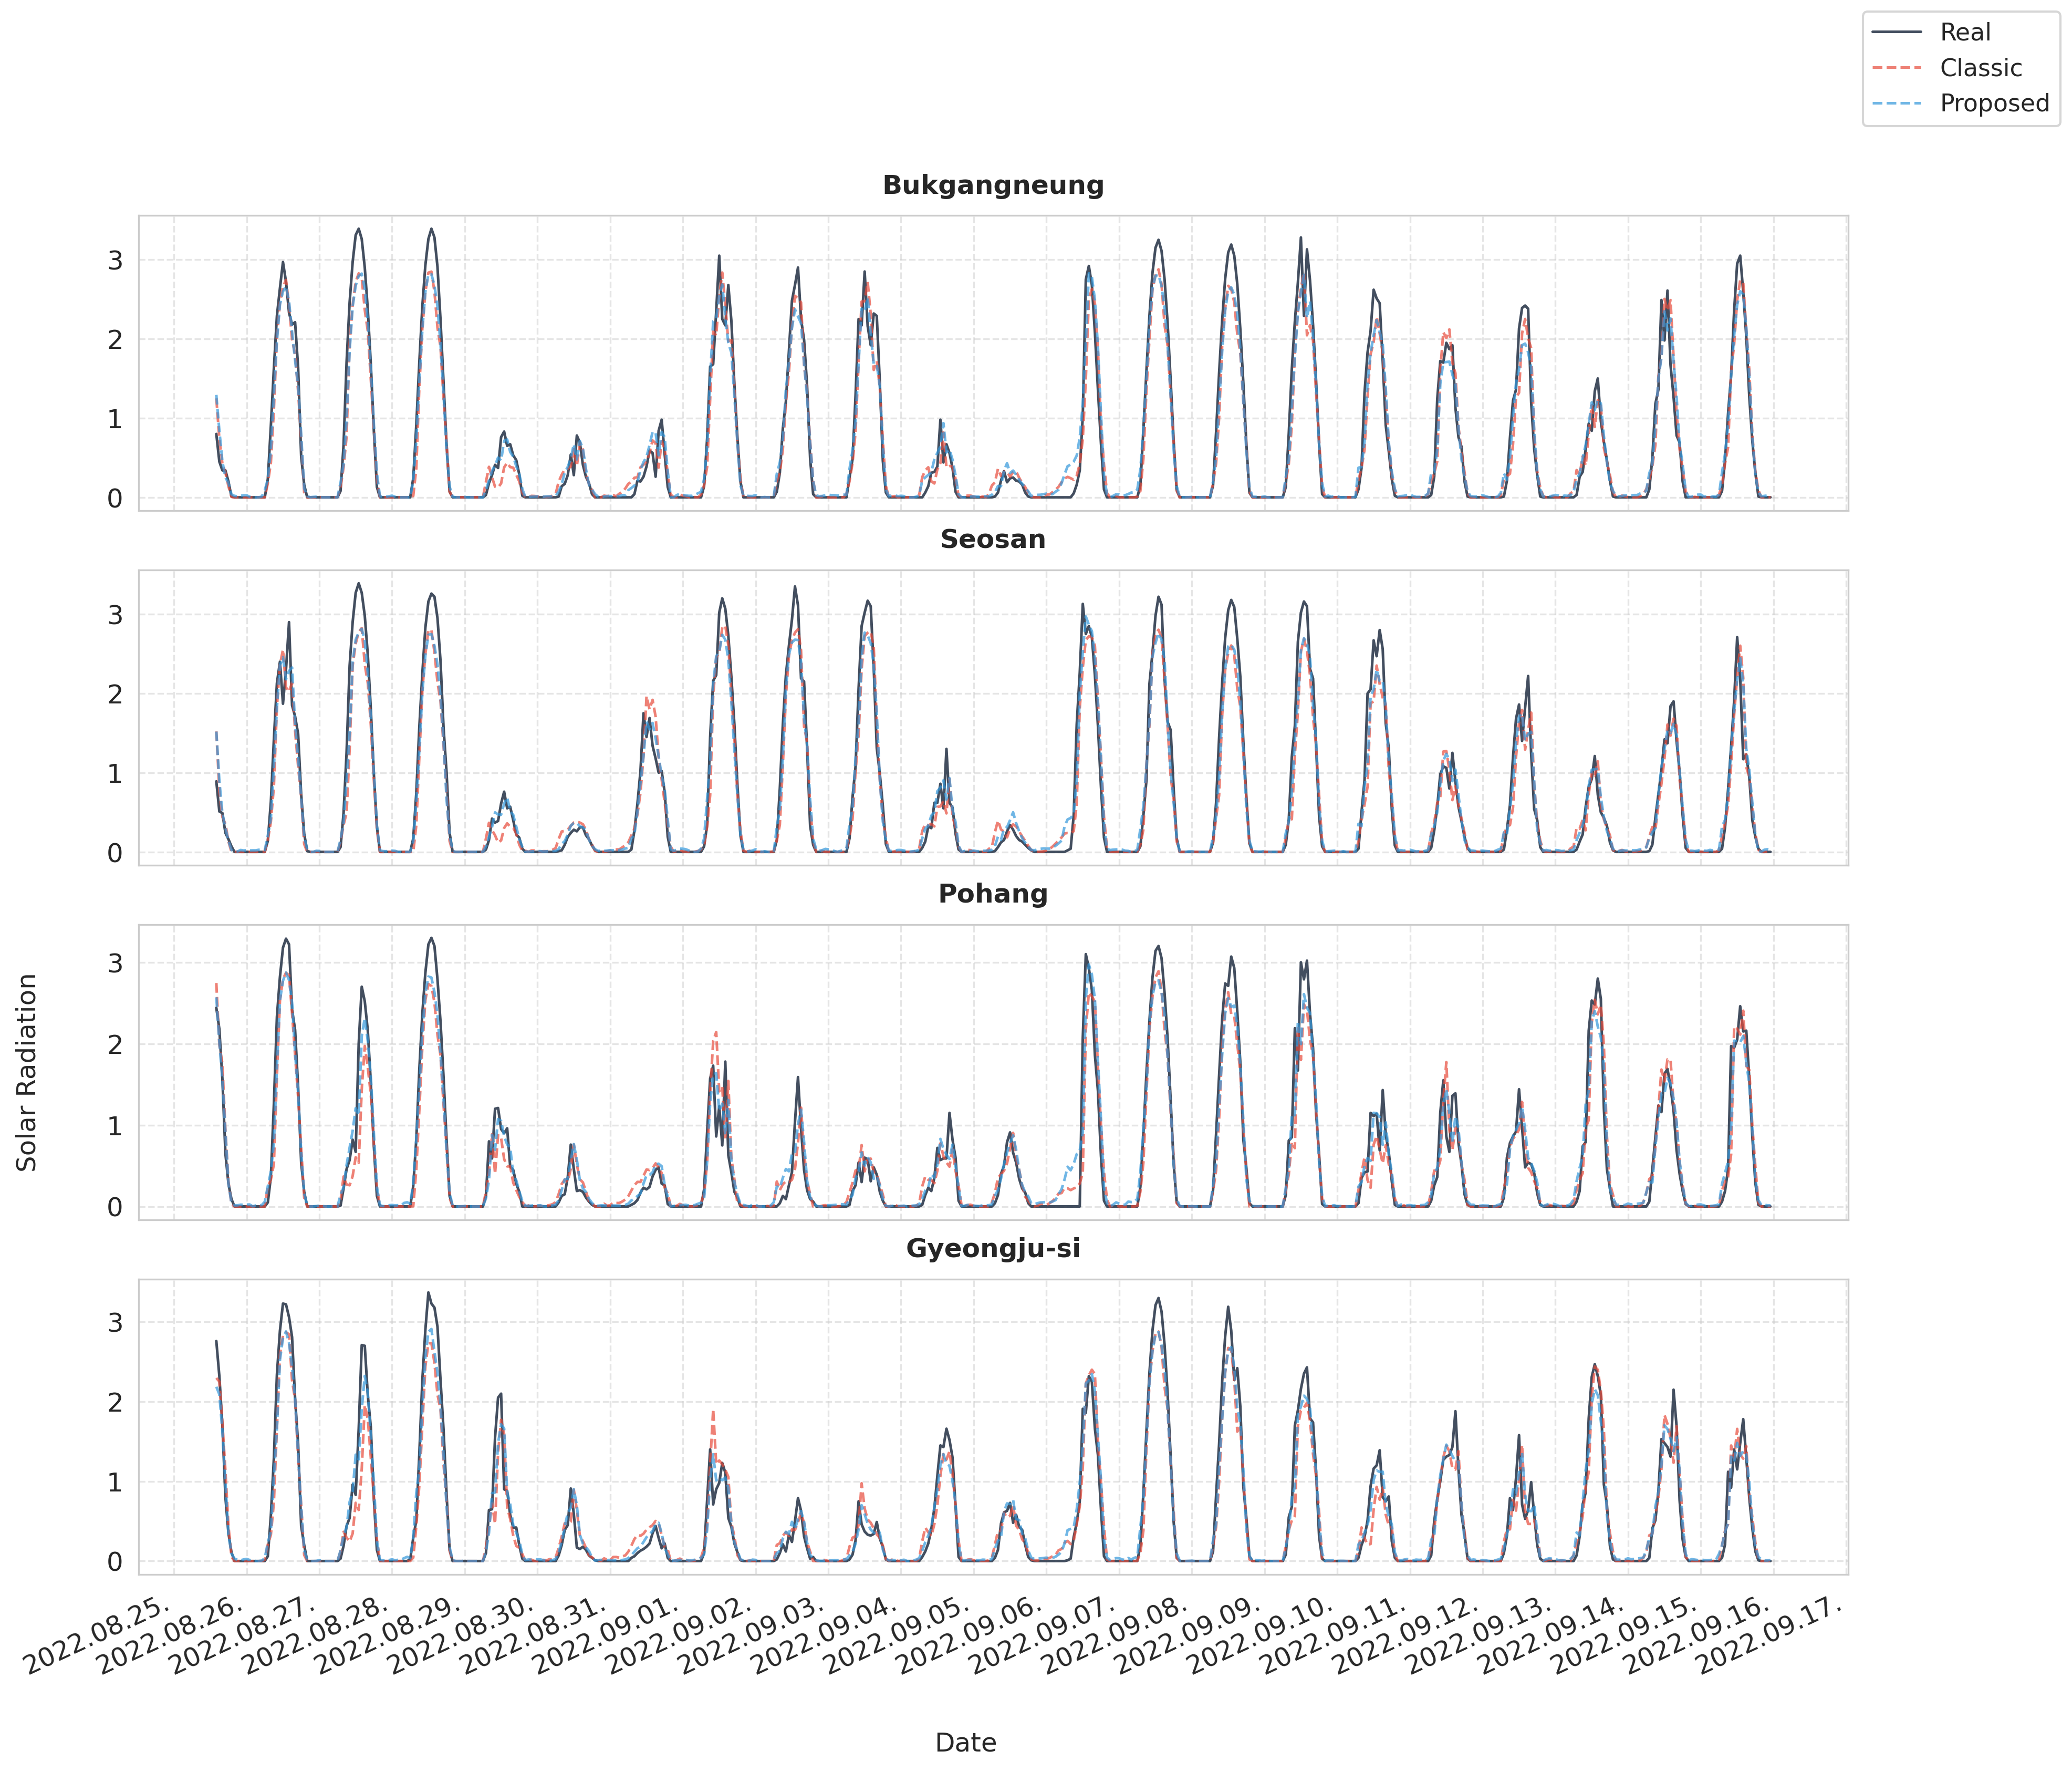

In [ ]:
# 시각화할 지역 인덱스 선택 (예: 3개 지역)
city_indices = [5, 12, 17, -1]

plot_test_results_multiple(t_test, y_test, yhat_test, yUhat_test, yPhat_test, regions, city_indices, save_path="test_results_multiple.pdf")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residual_densities(y_test, yhat_test, yUhat_test, yPhat_test, regions, save_path="residual_densities.pdf"):
    """
    모든 지역에 대해 Classic / Proposed 모델의 squared residual을 KDE와 함께 시각화하는 함수.

    Args:
        y_test (np.ndarray): 실제 값 (테스트).
        yhat_test (np.ndarray): 기존 모델 예측값 (테스트).
        yUhat_test (np.ndarray): 개선 모델 (U) 예측값 (테스트).
        yPhat_test (np.ndarray): 개선 모델 (P) 예측값 (테스트).
        regions (list): 지역 목록.
        save_path (str, optional): 저장할 PDF 파일 경로.
    """
    num_cities = y_test.shape[1]  # 전체 지역 개수
    cols = 4  # ✅ subplot 열 개수 (한 줄에 4개)
    rows = (num_cities // cols) + int(num_cities % cols > 0)  # 필요 행 개수 계산

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 3 * rows), dpi=300)
    axes = axes.flatten()  # 1D 배열로 변환 (인덱싱 편하게)

    # ✅ 컬러 설정
    classic_color = "#E74C3C"   # 빨강 (Classic)
    proposed_color = "#3498DB"  # 블루 (Proposed)

    alpha_hist = 0.5  # ✅ 히스토그램 투명도 조정

    # ✅ 모든 지역의 residual을 가져와 범위 통일 (5~95 퍼센타일 기준)
    all_residuals = np.concatenate([(y_test - yhat_test).flatten(), 
                                    (y_test - (yUhat_test * yPhat_test)).flatten()])
    xlim = (np.percentile(all_residuals, 5), np.percentile(all_residuals, 95))

    for i in range(num_cities):
        ax = axes[i]

        # ✅ Residual 계산
        residual_classic = y_test[:, i] - yhat_test[:, i]
        residual_proposed = y_test[:, i] - (yUhat_test * yPhat_test)[:, i]

        # ✅ 히스토그램 (Density 기반) + KDE (확률밀도 추정)
        sns.histplot(residual_classic, bins=30, color=classic_color, label="Classic", kde=False, 
                     alpha=alpha_hist, edgecolor="black", stat="density", ax=ax)
        sns.histplot(residual_proposed, bins=30, color=proposed_color, label="Proposed", kde=False, 
                     alpha=alpha_hist, edgecolor="black", stat="density", ax=ax)

        # ✅ KDE 곡선 추가
        sns.kdeplot(residual_classic, color=classic_color, linewidth=2, ax=ax)
        sns.kdeplot(residual_proposed, color=proposed_color, linewidth=2, ax=ax)

        # ✅ x=0 수직선 추가
        ax.axvline(x=0, color="red", linestyle="--", linewidth=1.5, alpha=0.8)

        # ✅ 지역명 타이틀 추가
        ax.set_title(f"{regions[i]}", fontsize=10, fontweight='bold')

        # ✅ X축, Y축 범위 통일
        ax.set_xlim(xlim)
        ax.set_ylim(0, None)  # 자동으로 조절되도록 설정

        # ✅ X축 라벨 설정
        ax.set_xlabel("Residual", fontsize=9)
        ax.set_ylabel("Density", fontsize=9)

        # ✅ 격자 설정
        ax.grid(True, linestyle="--", alpha=0.5)

    # ✅ 빈 subplot 제거
    for j in range(num_cities, len(axes)):
        fig.delaxes(axes[j])

    # ✅ 전체 범례 설정 (공통)
    fig.legend(["Classic", "Proposed"], loc="upper right", fontsize=11, frameon=True, framealpha=0.8)

    # ✅ 제목 추가
    fig.suptitle("Residual Density (Classic vs Proposed)", fontsize=14, fontweight='bold', y=1.02)

    # ✅ 간격 자동 조정
    plt.tight_layout()

    # ✅ PDF 저장
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    print(f"Residual 밀도 플롯이 '{save_path}'에 저장되었습니다.")

    # 그래프 출력
    plt.show()

✅ Residual 히스토그램이 'residual_histograms.pdf'에 저장되었습니다.


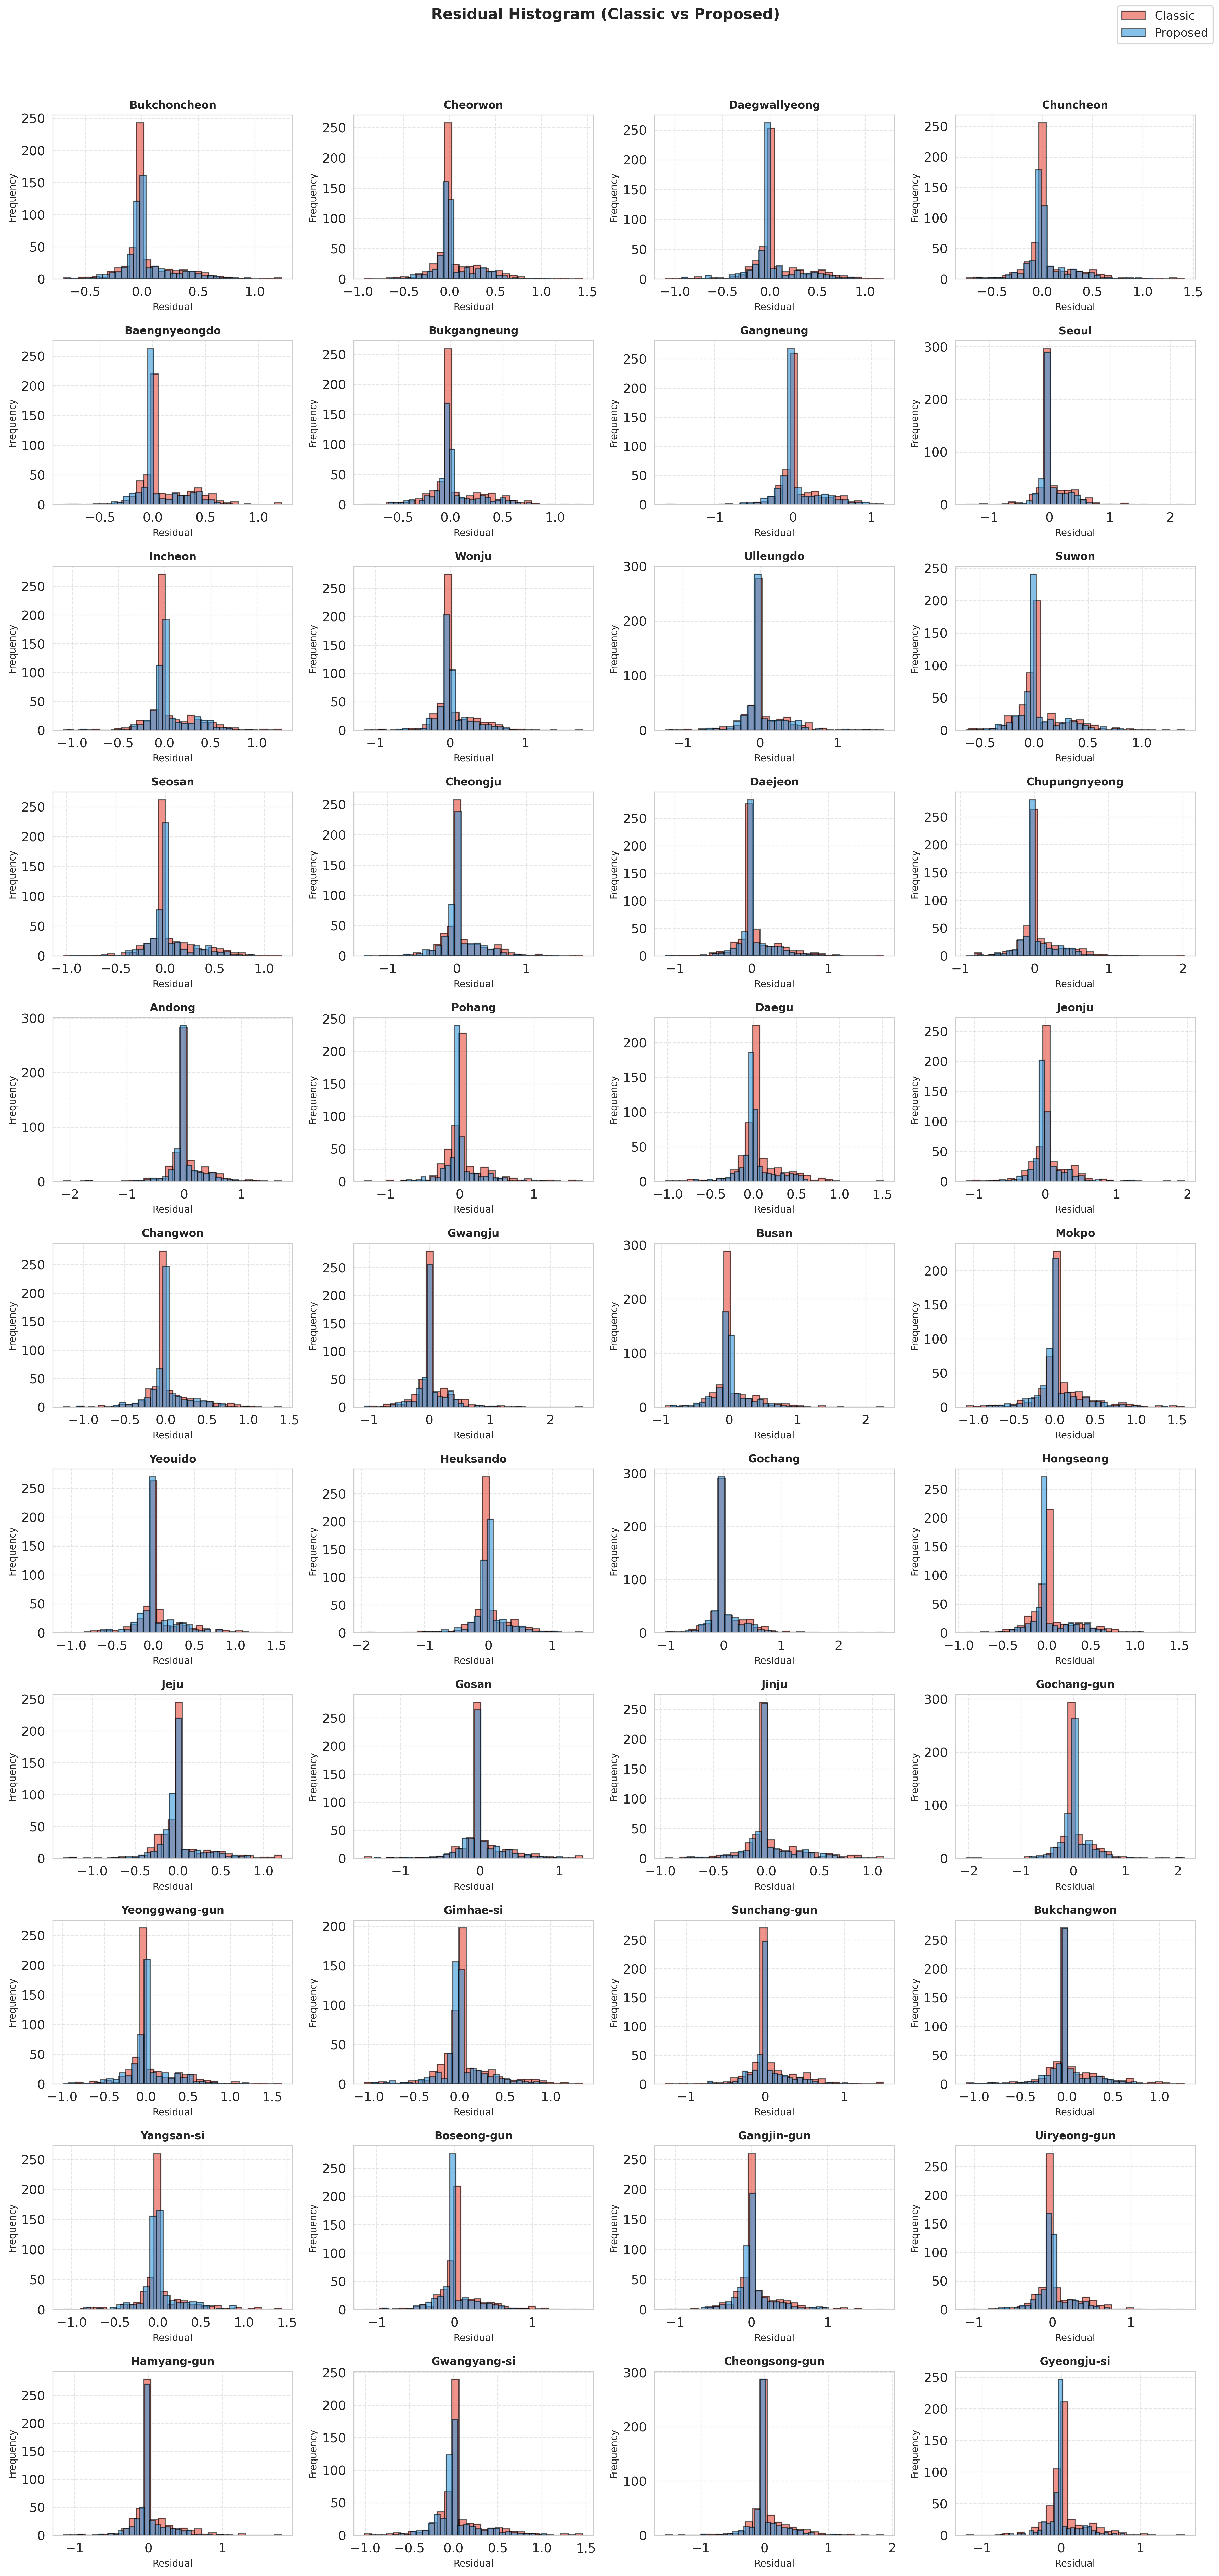

In [ ]:
plot_residual_histograms(y_test, yhat_test, yUhat_test, yPhat_test, regions, save_path="residual_histograms.pdf")